In [453]:
import re

from matplotlib import pyplot as plt

from socketudp.hex_check import HexCheck
%load_ext autoreload
%autoreload 2

import numpy as np


from extinction_plots import plot_normalized_histogram
from extinction_functions import simulate_delta_train, get_delta_trains_from_hex, \
    get_three_fold_coincidence_points, symmetric_mod, \
    combine_periods, deep_reload, get_delta_trains_per_event_from_hex

import hex_check as hc_mod
from socketudp.hex_check_classes import NewEvent, PeakArea

# Force a clean reload order: deps first, then dependents
deep_reload("hex_check")

# Rebuild the object so it picks up new config/code
hc = hc_mod.build_hex_check(plot=False, new=True)

# np_seterr(all='raise')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reloaded hex_check_config
Reloaded hex_check_classes

Reloaded hex_check
ℹ️ℹ️ Info: Multiple .dat files found in the current directory. Picking this one (data_20251223_145502.dat) ℹ️ℹ️
⚠️⚠️ Truncated hex data to last valid event ending at index 6895720. Cut last 0.72% of data. ⚠️⚠️
Using input file data_20251223_145502.dat
# Peakfinding Length: 300000000
# Number of subevents: 100
# Raw Data Length: 0
# Peakfinding Threshold: -100
# Peak height event count: 100
# Peak area event count: 300
# FPGA Test Mode: 0
# top_fmc228_pcie_v27.1.bit
Found 24 events in the file.
Event 14221-20 has 32 sub-events.
[14221-20-0] [PEAK_HEIGHT] 4 channels, lengths [0, 50, 50, 50].
[14221-20-0] [PEAK_AREA] 4 channels, lengths [0, 50, 50, 50].
[14221-20-1] [PEAK_HEIGHT] 4 channels, lengths [0, 50, 50, 50].
[14221-20-1] [PEAK_AREA] 4 channels, lengths [0, 50, 50, 50].
[14221-20-2] [PEAK_HEIGHT] 4 channels, lengths [0, 50,

In [454]:
from socketudp.extinction_plots import plot_raw_data

# plot_raw_data(hc, event_range=(0,5), n_subevents=99, figsize=(20, 14),
#               plotting_units='raw',
#               # t_range=(1130,1330),
#               # y_range=(-0.03, 0.005),
#               )

Peak widths (n=8000): mean=21.814 samples, median=16, std=22.0736
min=4, max=204
area-weighted mean = 34.8599 samples


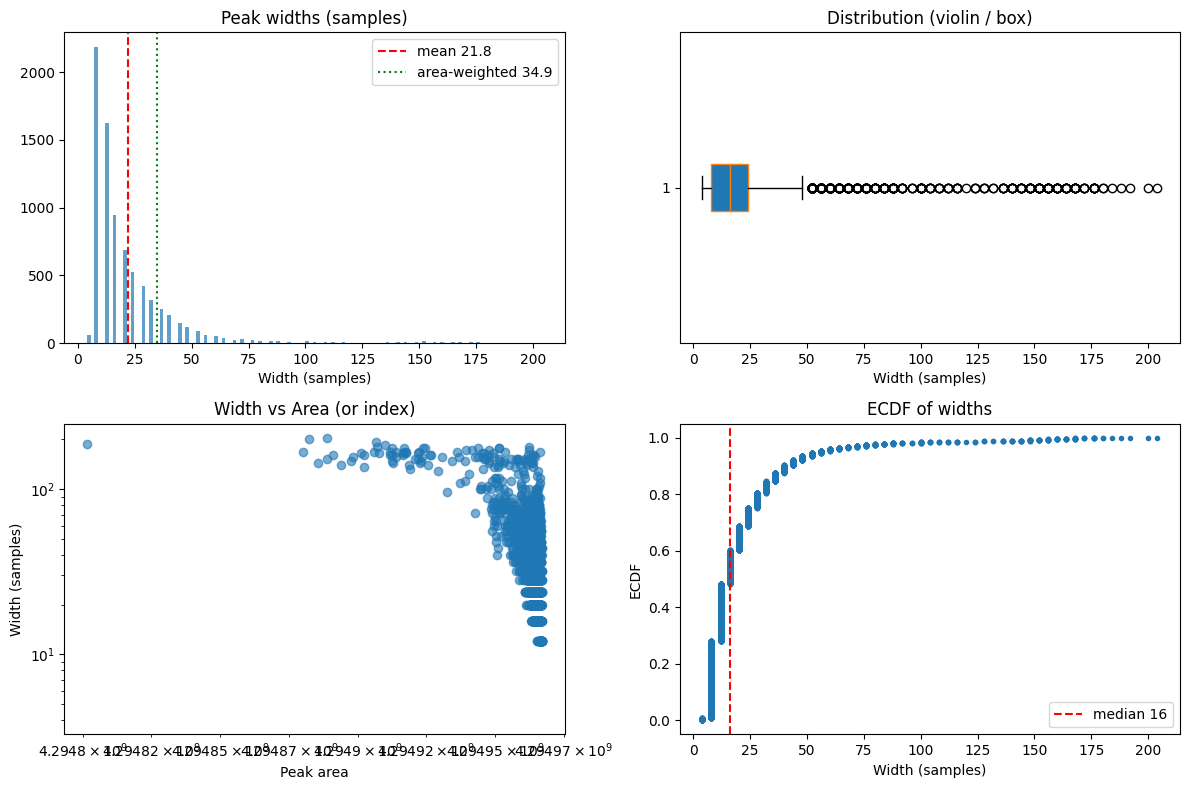

Peak widths (n=7858): mean=9.9029 samples, median=7, std=11.7333
min=1, max=277


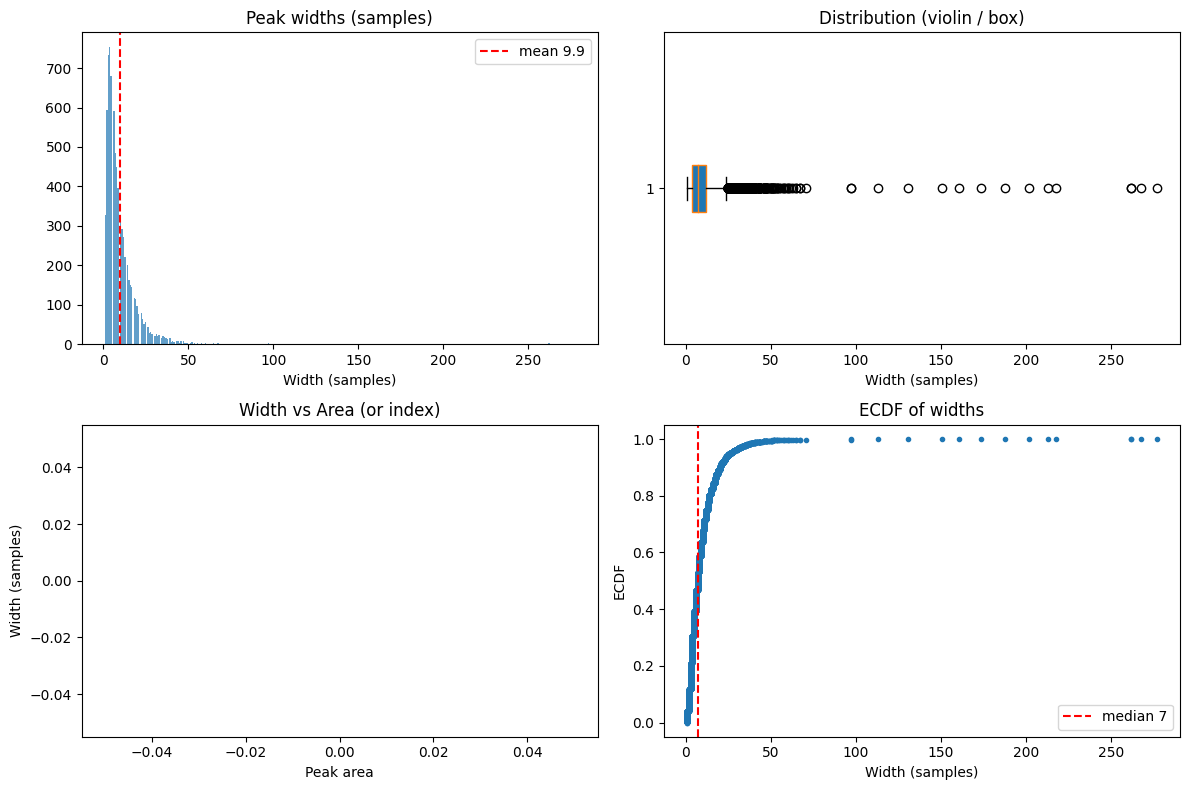

In [455]:
from socketudp.hex_check_classes import PeakHeight
from socketudp.extinction_plots import peak_width_classification

# Calculate average width in time of peaks from peak area packets

peak_areas: list[PeakArea] = []
peak_heights: list[PeakHeight] = []
for event in hc.event_buffer:
    event: NewEvent
    for subevent in event.sub_events:
        # print(subevent.peak_area_list)
        peak_areas += subevent.peak_area_list[1]
        peak_heights += subevent.peak_height_list[1]

# print(peak_areas[0], len(peak_areas))
# print(peak_heights[0], len(peak_heights))

# peak_widths = [p.peak_width for p in peak_areas]

peak_width_classification(peak_areas)
peak_width_classification(peak_heights, type="height")  # this plots peak heights, but plots will all be labeled as "width/area"

In [456]:
# last_event = hc.event_buffer[-1]
# print(f"# Events / Subevents: {last_event.internal_event_number} / {last_event.sub_event_number}")

# all times in this file are in nanoseconds unless otherwise specified
signal_period = 1 / 589.9801  # ns, the nominal period of the signal, 1694.97242 ns
sample_rate = 4  # ns, the sampling rate of the signal (4 ns per sample)

use = "real_data"  # "real_data" or "simulated_data"
# FOR SIMULATED DATA
length_ms = 30
length_ns: int = int(length_ms * 1e6)  # ns, total time for the delta train
# arrival_jitter derived based on requirement for ~99.99893% of protons within ±125 ns
arrival_jitter_ns = 27.14
particle_num_mean = 3
particle_num_width = 2
noise_num_mean = 0.1
noise_num_width = 0.15
phase_offset_deg = 0
gradual_phase_shift_speed_ns = 5  # ns, the speed of the gradual phase shift in the signal

# OTHER SETTINGS
desired_f_resolution = 0.1  # kHz, desired frequency resolution for the FFT
zero_padding_ratio = 5  # set to None to calc. zero padding based on desired_f_resolution
common_title_text = ""  # leave unfilled, is set at beginning of main()

# 4 ns sample rate
# total_time = 1695 * 501 ns = 849,195 ns = 0.849195 ms
# fs = 1 / (4e-9) = 250 MHz
# fn = fs / 2 = 125 MHz
print(f"Sampling rate (fs): {1 / sample_rate * 1e6} MHz ({sample_rate} ns)")
print(f"Nyquist frequency (fn): {1 / (2 * sample_rate) * 1e6} MHz ({2 * sample_rate} ns)")

if use == 'real_data':
    common_title_text = f"{hc.file_name}"
else:
    common_title_text = f"Simulated Delta Train (length: {length_ms} ms, "
    common_title_text += f"signal period: {signal_period} ns, sample rate: {sample_rate} ns)"

Sampling rate (fs): 250000.0 MHz (4 ns)
Nyquist frequency (fn): 125000.0 MHz (8 ns)


In [457]:
def get_delta_train(channel, fft_time_range_ns: tuple[float, float] = (None, None)):
    global common_title_text
    if use == "real_data":
        delta_train, fft_time_range_ns = get_delta_trains_from_hex(hc, channel, fft_time_range_ns)
        if delta_train.size == 0:
            return delta_train, fft_time_range_ns
        print(delta_train[0], delta_train[-1], )
        if "Time Range" not in common_title_text:
            common_title_text += (f"\nTime Range: {delta_train[0] * 1e-6:.2f} "
                                  f"to {delta_train[-1] * 1e-6:.2f} ms")
    elif use == "simulated_data":
        delta_train = simulate_delta_train(signal_period, phase_offset_deg, arrival_jitter_ns,
                                           particle_num_mean, particle_num_width, noise_num_mean,
                                           noise_num_width,
                                           length_ns, sample_rate)
        fft_time_range_ns = (delta_train[0], delta_train[-1])  # default to full range
    else:
        raise ValueError("Invalid use case. Use 'real_data' or 'simulated_data'.")

    return delta_train, fft_time_range_ns

File name: data_20251223_145502.dat
[CH1] Event 20: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH1] Event 21: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH1] Event 22: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH1] Event 23: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH1] Event 24: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH1] Received 5 delta trains
Converting data from ns to ms for histogram plot.


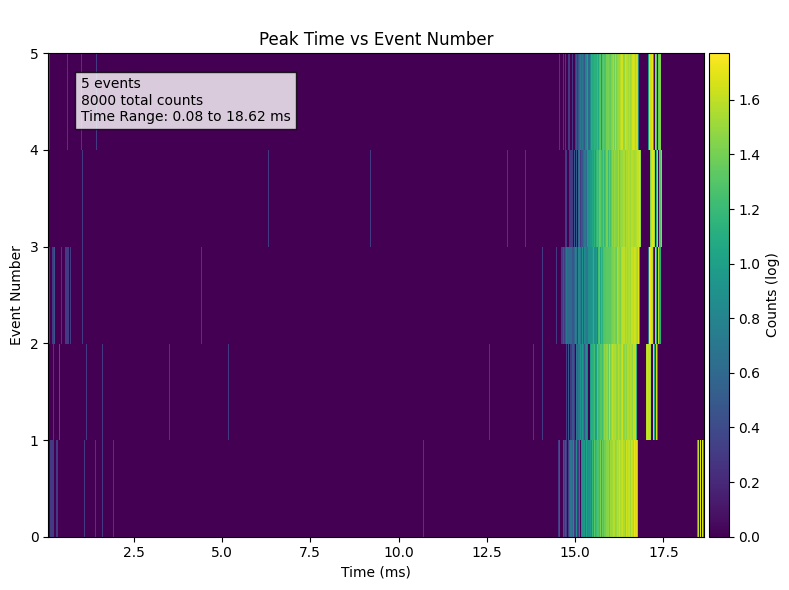

Converting data from ns to ms for histogram plot.


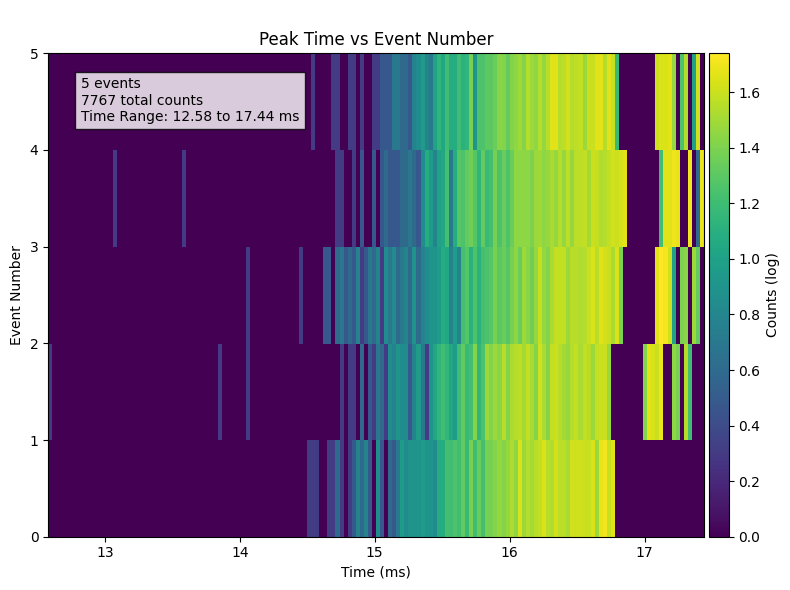

[CH2] Event 20: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH2] Event 21: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH2] Event 22: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH2] Event 23: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH2] Event 24: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH2] Received 5 delta trains
Converting data from ns to ms for histogram plot.


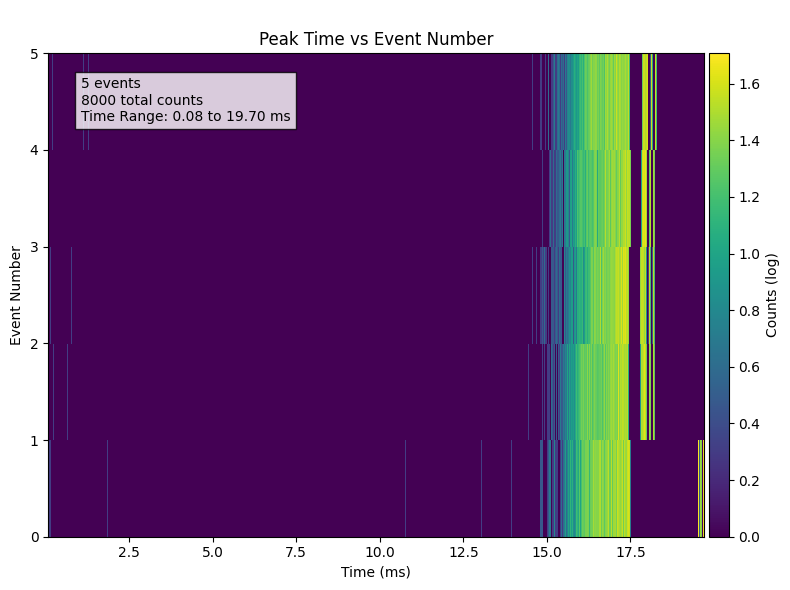

[CH3] Event 20: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH3] Event 21: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH3] Event 22: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH3] Event 23: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH3] Event 24: 1600 peaks heights(1600 from t = 0 to 40000000.0 ns).
[CH3] Received 5 delta trains
Converting data from ns to ms for histogram plot.


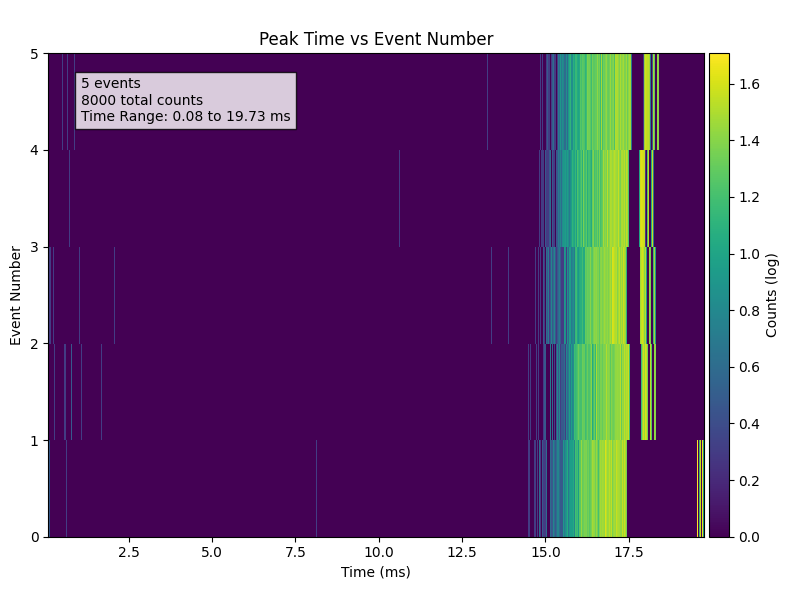

[CH4] Received 0 delta trains
No data in specified t_range; nothing to plot.


In [458]:
from extinction_plots import plot_2d_histogram_time_vs_event_number

def get_delta_train_per_event(channel: int,
                              fft_time_range_ns: tuple[float, float] = (None, None),
                              period=None):
    """
    Get delta train for a specific channel and event.
    :param channel: Channel number (1, 2, or 3).
    :param fft_time_range_ns: Time range for FFT in nanoseconds.
    :return: Delta train and time range for FFT.
    """
    r = get_delta_trains_per_event_from_hex(hc, channel, fft_time_range_ns, units='ns', period=period)
    return r

# t_range_begin_ns = 29.5e6
# t_range = (t_range_begin_ns, t_range_begin_ns + 1695*15)
t_range = (0, 40e6)
print(f"File name: {hc.file_name}")

for i in range(4):
    delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=i+1,
                                                                            fft_time_range_ns=t_range)
    print(f"[CH{i+1}] Received {len(delta_trains_per_event)} delta trains")


    plot_2d_histogram_time_vs_event_number(
        delta_trains_per_event,
        bin_width = 0.03,
        units='ms',
        t_range=(0, 40e6)
    )

    if i == 0:
        plot_2d_histogram_time_vs_event_number(
        delta_trains_per_event,
        bin_width = 0.03,
        units='ms',
        t_range=(12.5e6, 17.5e6)
    )

[CH1] Using real data from channel 1 with 8000 events.
[CH1] First event time: 77776.00 ns, 
77776 18620268

[CH2] Using real data from channel 2 with 8000 events.
[CH2] First event time: 77784.00 ns, 
77776 19696572

[CH3] Using real data from channel 3 with 8000 events.
[CH3] First event time: 77820.00 ns, 
77796 19732156

[CH1] Total time: 18.542 ms
[CH1] Expected theoretical peak width: 0.0539 kHz
[CH1] Zero padding ratio: 5 (to achieve 0.0108 kHz interpolated resolution)
Cutting off freqs below [0.00000000e+00 1.01725260e-05 2.03450521e-05 ... 6.24999695e+01
 6.24999797e+01 6.24999898e+01] kHz
[CH1] FFT Peak Frequency: 589.996 kHz, Amplitude: 5732.186 (searched between 589.569 kHz and 590.424 kHz)
[CH1] Signal power: 3.286e+07 W, Average noise bin: 4.635e+03 W, Noise density: 9.110e+01 W/Hz, SNR: 360683.43 (T = 18.542492 ms, zero padding ratio = 5)
[CH1] Fitted frequency: 589.999 ± 0.0008 ± 0.0006 kHz (SNR error, fit error)
[CH1] Fitted period: 1694.9186 ± 0.0023 ± 0.0016 ns (SNR 

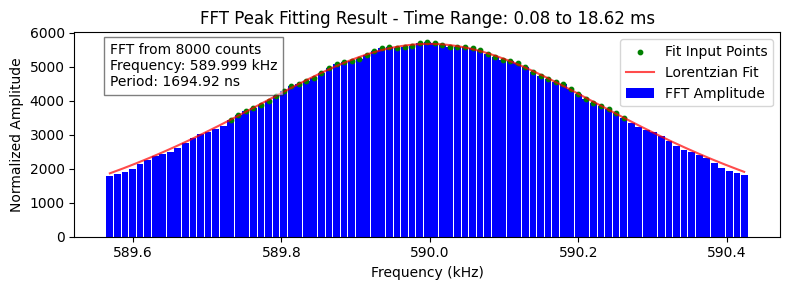


[CH2] Total time: 19.619 ms
[CH2] Expected theoretical peak width: 0.0510 kHz
[CH2] Zero padding ratio: 5 (to achieve 0.0102 kHz interpolated resolution)
Cutting off freqs below [0.00000000e+00 1.01725260e-05 2.03450521e-05 ... 6.24999695e+01
 6.24999797e+01 6.24999898e+01] kHz
[CH2] FFT Peak Frequency: 589.996 kHz, Amplitude: 6023.307 (searched between 589.600 kHz and 590.403 kHz)
[CH2] Signal power: 3.628e+07 W, Average noise bin: 5.356e+03 W, Noise density: 1.053e+02 W/Hz, SNR: 344663.02 (T = 19.618796 ms, zero padding ratio = 5)
[CH2] Fitted frequency: 589.996 ± 0.0008 ± 0.0003 kHz (SNR error, fit error)
[CH2] Fitted period: 1694.9268 ± 0.0022 ± 0.0009 ns (SNR error, fit error)


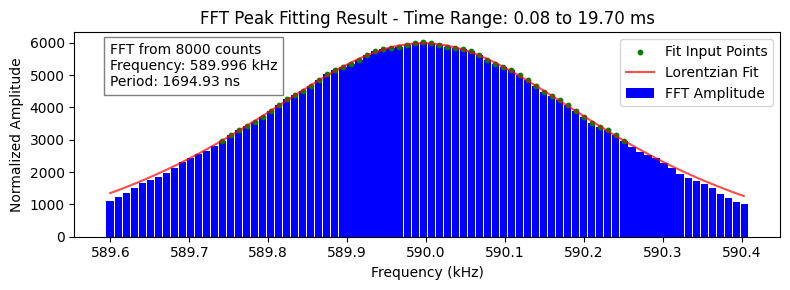


[CH3] Total time: 19.654 ms
[CH3] Expected theoretical peak width: 0.0509 kHz
[CH3] Zero padding ratio: 5 (to achieve 0.0102 kHz interpolated resolution)
Cutting off freqs below [0.00000000e+00 1.01725260e-05 2.03450521e-05 ... 6.24999695e+01
 6.24999797e+01 6.24999898e+01] kHz
[CH3] FFT Peak Frequency: 589.996 kHz, Amplitude: 5784.298 (searched between 589.600 kHz and 590.403 kHz)
[CH3] Signal power: 3.346e+07 W, Average noise bin: 5.843e+03 W, Noise density: 1.148e+02 W/Hz, SNR: 291354.12 (T = 19.65436 ms, zero padding ratio = 5)
[CH3] Fitted frequency: 589.995 ± 0.0008 ± 0.0003 kHz (SNR error, fit error)
[CH3] Fitted period: 1694.9299 ± 0.0024 ± 0.0009 ns (SNR error, fit error)


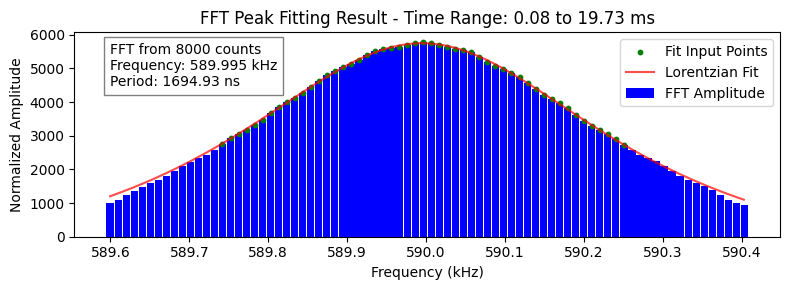


Averaged Period: 1694.925075 ns, Error: 0.002747 ns (std.dev error)
Input mean: 1694.925075356 ns
Weighted mean: 1694.925578753 ns
Weighted error (uncorrelated only): ±0.001468 ns
Chi²/dof: 9.3560 / 2 = 4.6780
Birge ratio: 2.163
Final result: 1694.925578753 ± 0.003174 ns


In [459]:
from socketudp.extinction_functions import fft

fft_range = (0e6, 40e6)
ch1, fft_range_1 = get_delta_train(1, fft_range)
# ch1 = np.array([])  # use if ch1 is just the trigger pulse
print()
ch2, fft_range_2 = get_delta_train(2, fft_range)
print()
ch3, fft_range_3 = get_delta_train(3, fft_range)
print()

chs: list[np.ndarray] = []
total_fft_range: tuple[float, float] | tuple[float, float] = (np.inf, -np.inf)
for ch in [ch1, ch2, ch3]:
    if ch.size > 0:
        chs.append(ch)
        # recalculate total min/max range with new ch
        total_fft_range = (min(total_fft_range[0], min(ch)), max(total_fft_range[1], max(ch)))

# Run three FFTs / calculate average period
periods: list[float] = []
period_errors: list[float] = []
delta_trains: list[np.ndarray] = []

for i in range(len(chs)):
    r = fft(i+1,
            chs[i],
            fft_time_range_ns = (total_fft_range[0], total_fft_range[1]),
            expected_peak_khz=590,
            sample_rate=sample_rate, desired_f_resolution=desired_f_resolution, hc=hc,
            signal_period=signal_period, length_ns=length_ns, common_title_text=common_title_text, zero_padding_ratio=zero_padding_ratio)
    delta_trains.append(r[0])
    periods.append(r[1])
    period_errors.append(r[2])
    print()

# ##########
# COMBINE PERIODS
# ##########
period = float(np.mean(periods))
period_error = np.std(periods) / np.sqrt(len(periods))
print(f"Averaged Period: {period:.6f} ns, Error: {period_error:.6f} ns (std.dev error)")

weighted_period, final_error = combine_periods(period, periods, period_errors)

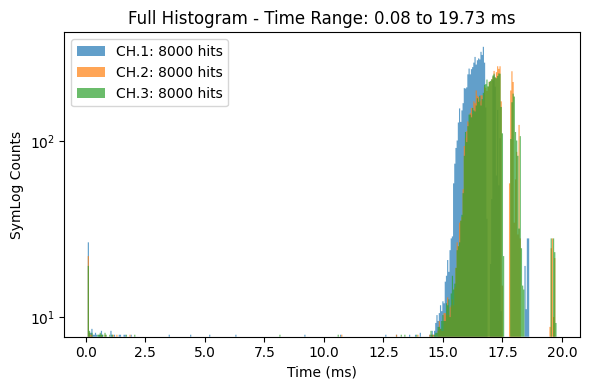

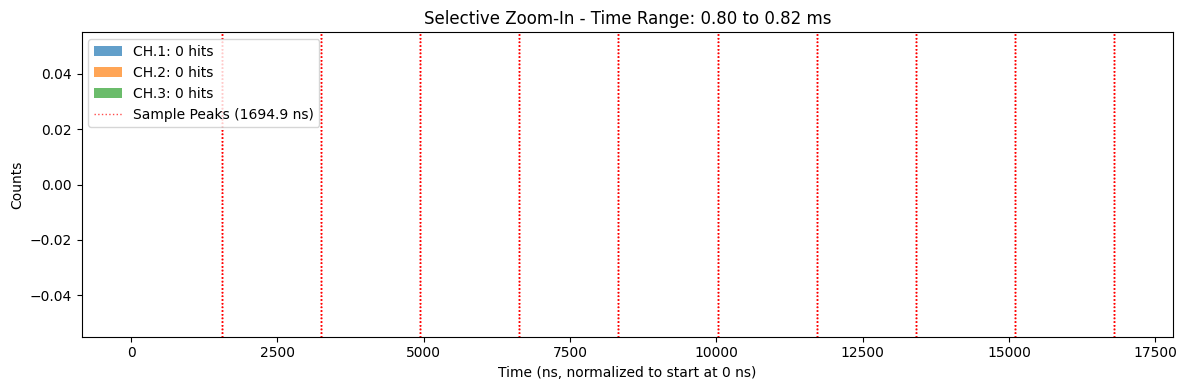

In [460]:
from extinction_plots import plot_1d_histogram

plot_1d_histogram(chs, common_title_text=common_title_text, hist_range=total_fft_range,
                  title=f"Full Histogram - Time Range: {total_fft_range[0] * 1e-6:.2f} to {total_fft_range[1] * 1e-6:.2f} ms",
                  fig_size=(6, 4), file_name=f"img/{hc.folder_name}/full_histogram.png", loc="upper left",
                  log=True, bin_size_ns=0.05e6, alpha=0.7)

# start = 32.5e6 - 32.5e6 % period - 500
start = 0.8e6
offset = 225
start = start - start % period - offset
end = start + period * 10

plot_1d_histogram(chs, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=period, hist_range=(start, end), loc="best", alpha=0.7, bin_size_ns=40,
                  fig_size = (12, 4), sample_offset=-150,
                  file_name=f"img/{hc.folder_name}/{hc.file_name}_zoomed_1d_histogram.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.2f} to {end * 1e-6:.2f} ms",
                  units='ns')


![hi](../documentation_texts/old/vladimir_beam_loss_slide_1.png)
![hi](../documentation_texts/old/vladimir_beam_loss_slide_2.png)
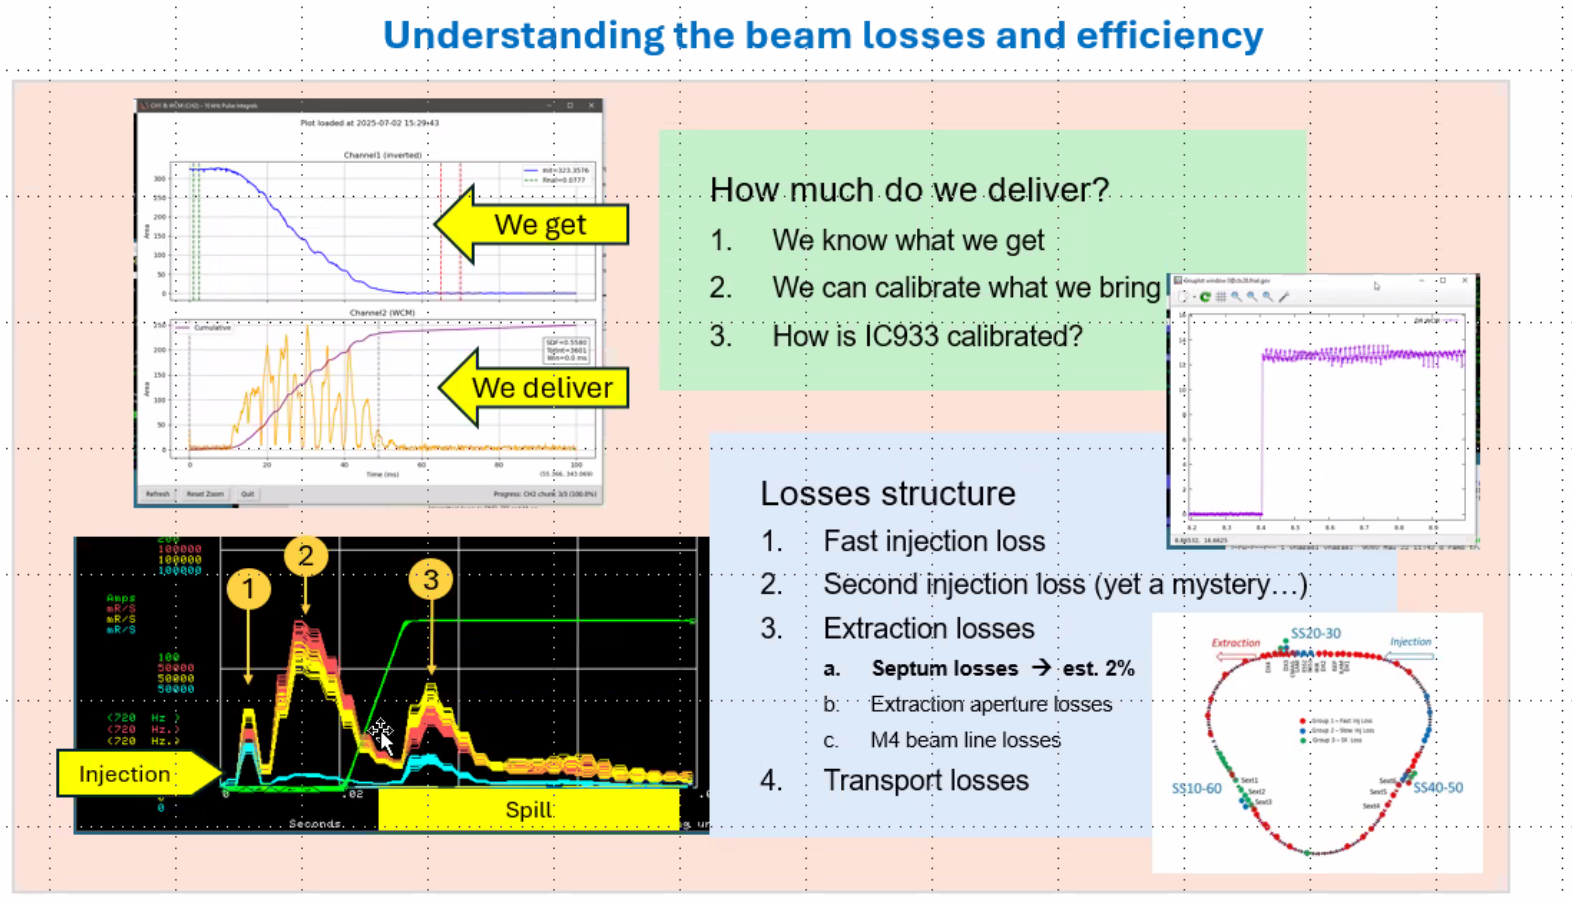
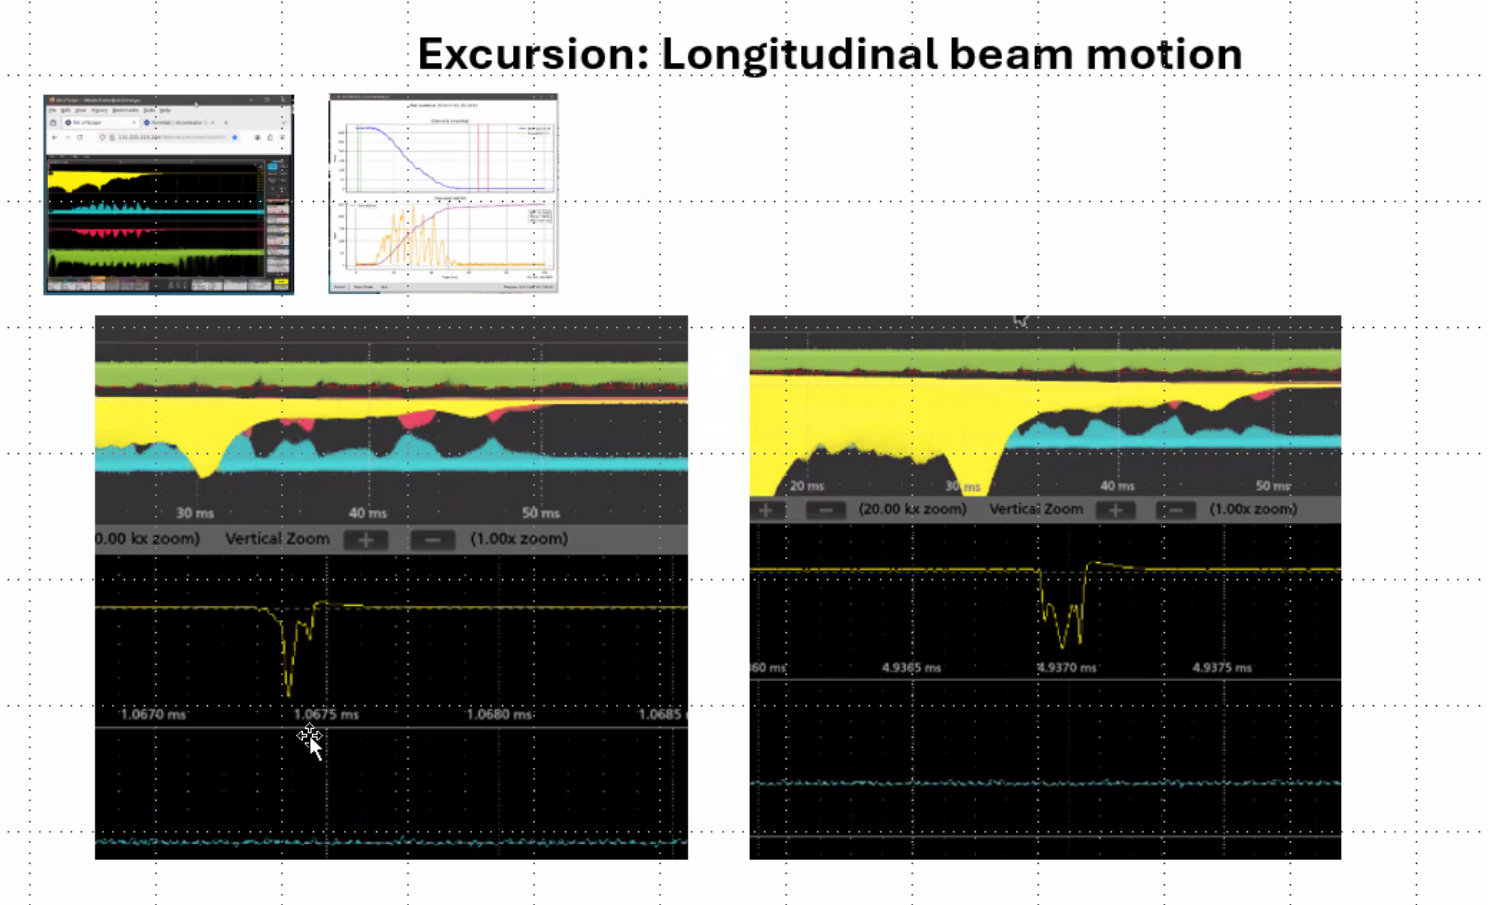
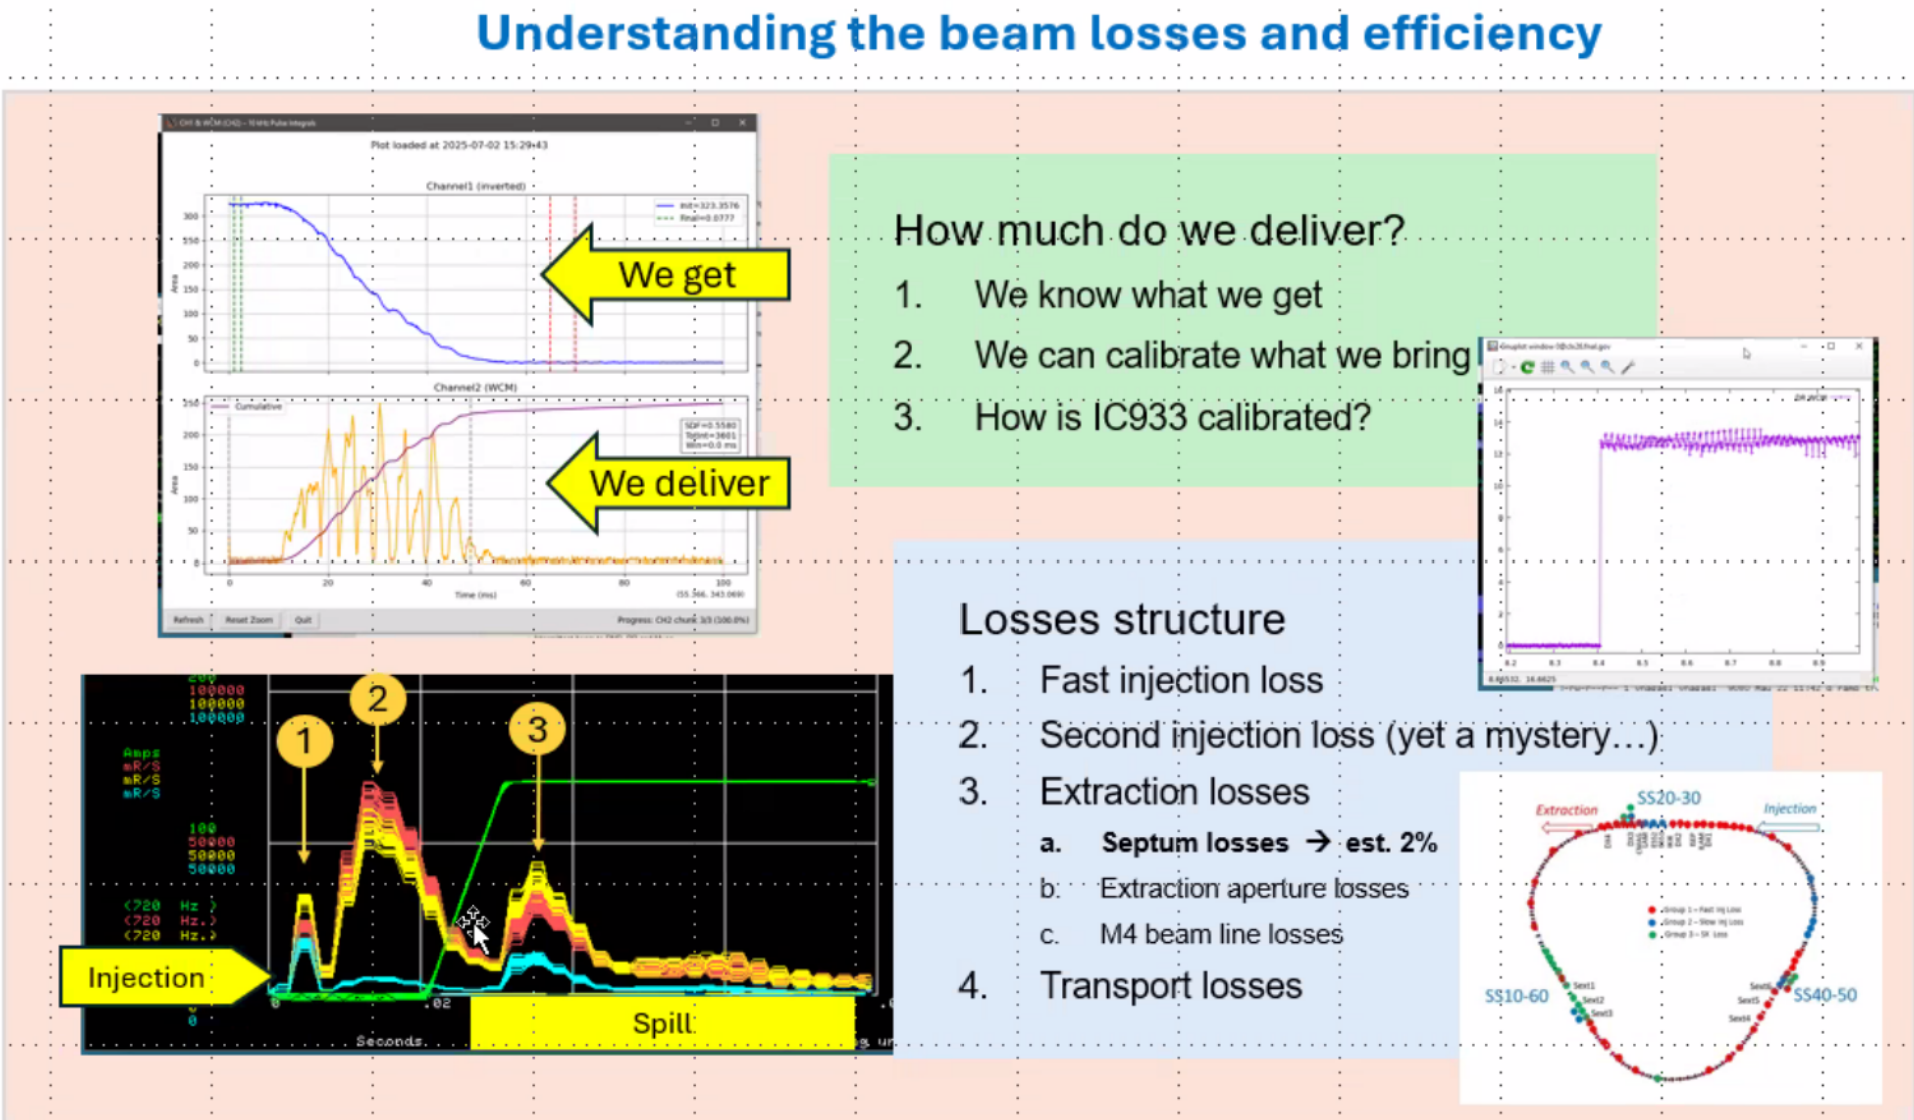

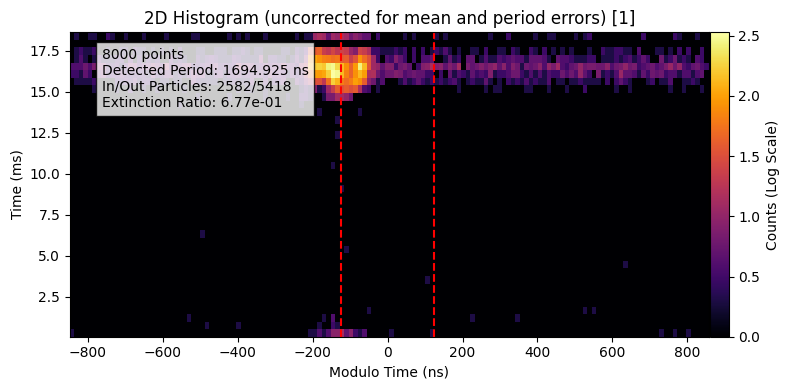

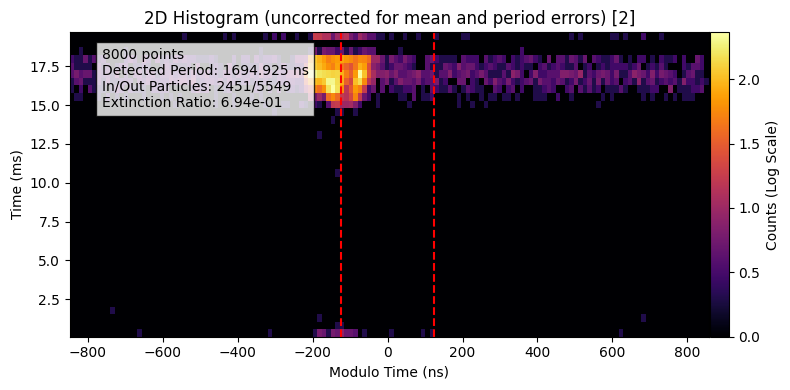

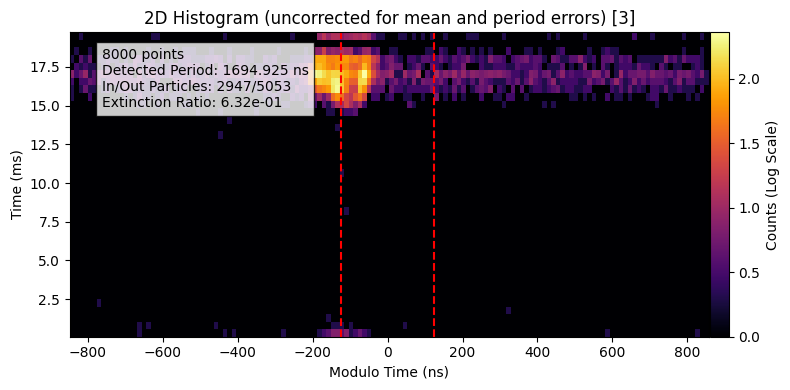

In [461]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################
from extinction_plots import plot_2d_histogram_delta_train

for channel, delta_train in enumerate(delta_trains):
    plot_2d_histogram_delta_train(delta_train, period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hc.folder_name}/2d_histogram_uncorrected.png",
                                  bin_width_ns = 12,
                                  n_slices=40,
                                  figsize=(8, 4), colors = ['inferno'],
                                  title=f"2D Histogram (uncorrected for mean and period errors) [{channel + 1}]")


[CH1] Normalized delta train mean: -98.113 ns, 
[CH2] Normalized delta train mean: -108.178 ns, 
[CH3] Normalized delta train mean: -93.062 ns, 


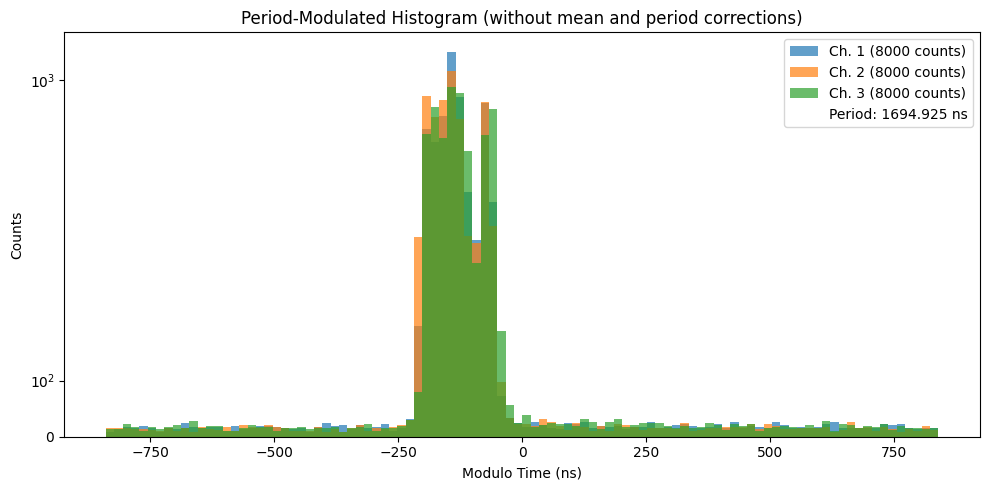

Initial means for each of the three trains: [ -98.112625 -108.177625  -93.061625] ns
Delta train mean value (combined channels): -99.78 ns
0) Center Beginning:
Correcting phase of delta train by 106 ns, new mean: -0.14 ns


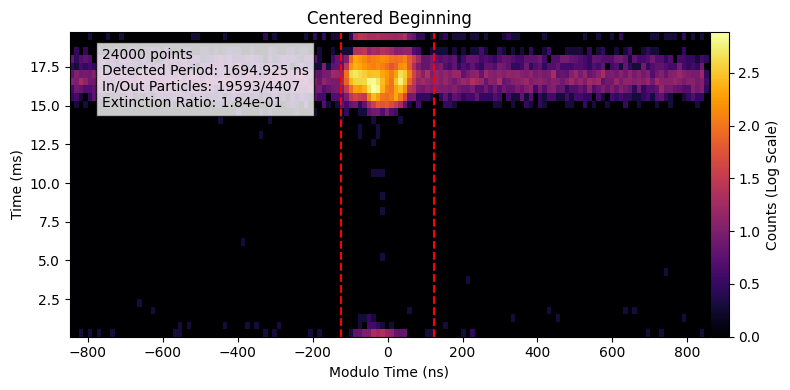

1) Correct Period:
  Mode 1: -20.09 ns (count=269)
  Mode 2: 4.39 ns (count=250)
  Mode 3: -40.52 ns (count=215)
  Mode 4: 25.73 ns (count=163)
  Mode 5: -67.00 ns (count=46)
  Mode 1: -68.13 ns (count=189)
  Mode 2: -18.87 ns (count=152)
  Mode 3: 3.83 ns (count=133)
  Mode 4: -42.89 ns (count=132)
  Mode 5: 50.20 ns (count=110)
[BinPeriod] start_mode=-19.50 ns (count=188), end_mode=-15.17 ns (count=143), drift=4.325 ns over 11596.02 cycles -> error/cycle=0.000373 ns, period 1694.925075 -> 1694.925448 ns


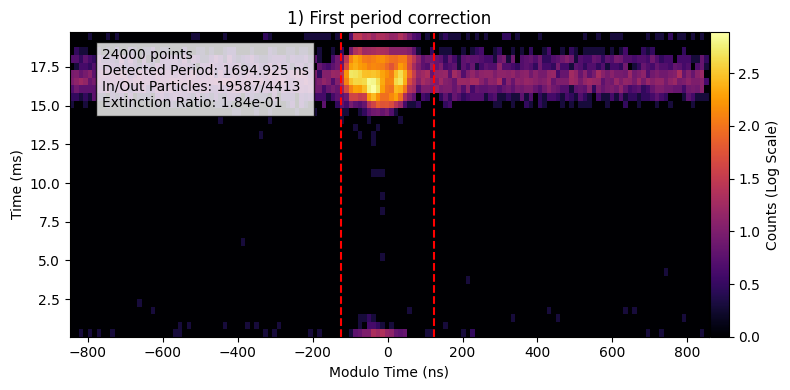

2) Correct Mean:
Correcting phase of delta train by 28 ns, new mean: -0.44 ns


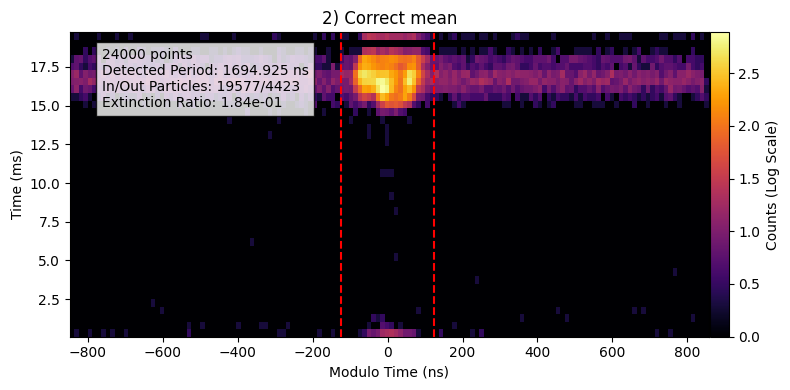

3) Correct Mean (Middle Focus):
Correcting phase of (center of) delta train by -8 ns, new mean: -0.27 ns


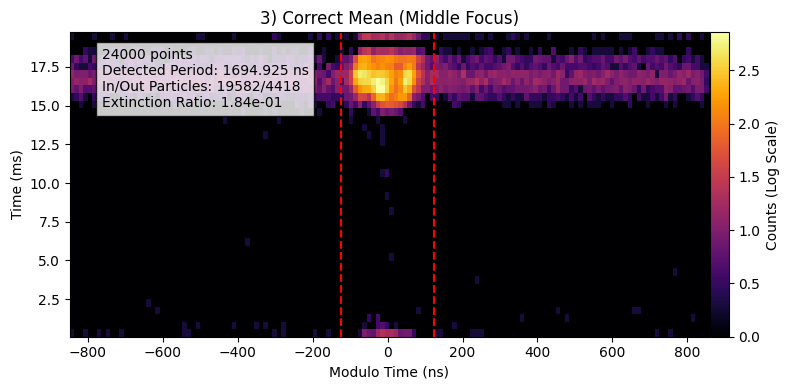

4) Correct Period (Middle Focus):
  Mode 1: 4.41 ns (count=258)
  Mode 2: -18.15 ns (count=256)
  Mode 3: 28.39 ns (count=234)
  Mode 4: 49.40 ns (count=96)
  Mode 5: -40.13 ns (count=55)
  Mode 1: -65.87 ns (count=172)
  Mode 2: -45.36 ns (count=160)
  Mode 3: 4.97 ns (count=156)
  Mode 4: -19.24 ns (count=147)
  Mode 5: 53.05 ns (count=119)
[BinPeriod] start_mode=4.78 ns (count=179), end_mode=-14.49 ns (count=150), drift=-19.272 ns over 11596.01 cycles -> error/cycle=-0.001662 ns, period 1694.925448 -> 1694.923786 ns


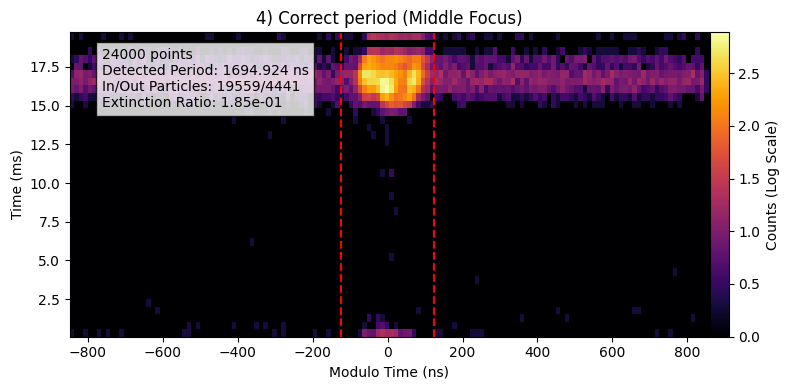

5) Correct Mean (Middle Focus):
Correcting phase of (center of) delta train by -3 ns, new mean: 0.33 ns


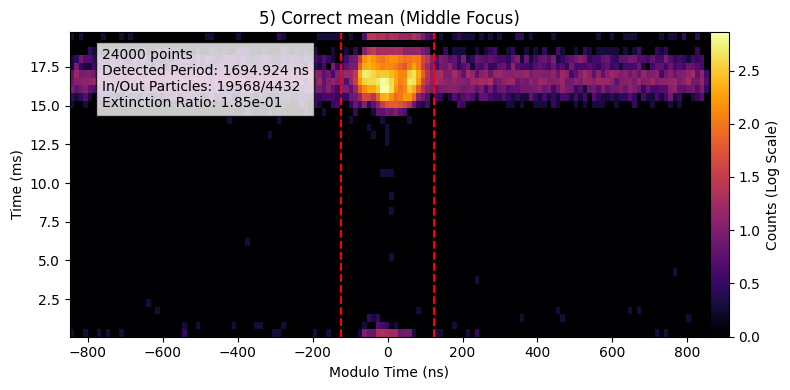

Total correction on the mean: 17 ns
Correcting phase of (center of) delta train by 95 ns, new mean: -0.33 ns
Correcting phase of (center of) delta train by 101 ns, new mean: 0.38 ns
Correcting phase of (center of) delta train by 87 ns, new mean: -0.22 ns
New means for each of the three trains:16.23 ms, 16.83 ms, 16.83 ms, 


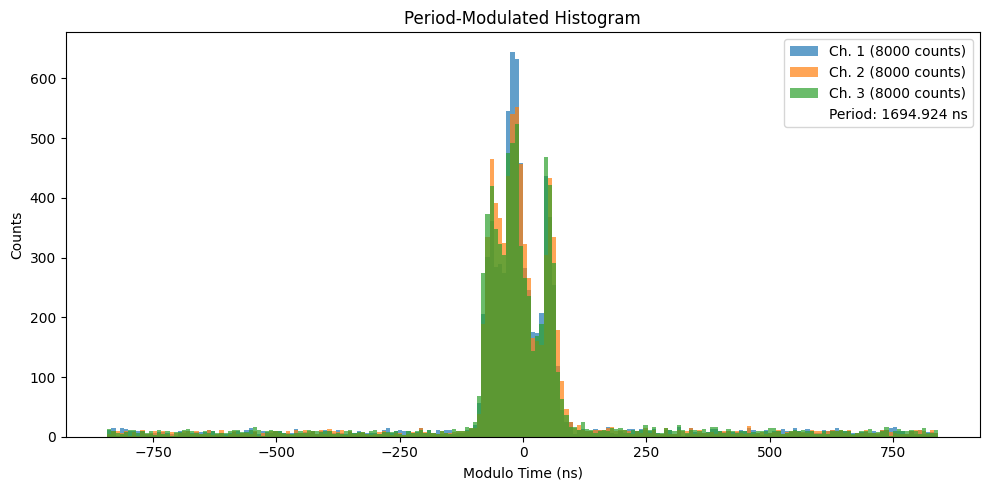

In [476]:
# #######################################################
# Pulse Centering
# #######################################################
from extinction_functions import center_pulses

# period = 1694.943 ... 0284359757
# new_period = 1694.933 0284359758
# new_period = period - 0.01

# normalize delta train by detected period once, but we will slightly nudge it to make it better now
normalized_delta_trains = []
for i, delta_train in enumerate(delta_trains):
    s = symmetric_mod(delta_train, period)
    print(f"[CH{i+1}] Normalized delta train mean: {s.mean():.3f} ns, ")
    normalized_delta_trains.append(s)
new_detected_period = period

# Plot histogram normalized by FFT period
plot_normalized_histogram(delta_trains, normalized_delta_trains, period, figsize=(10, 5),
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_normalized_histogram.svg",
                          title=f"Period-Modulated Histogram (without mean and period corrections)", log=True)

new_delta_trains, new_period, correction_to_mean = center_pulses(delta_trains, period)
normalized_delta_trains = [symmetric_mod(delta_train, new_period) for delta_train in new_delta_trains]

common_title_text = re.sub(r' - Channel \d', '', common_title_text)  # remove channel number from title

# Plot histogram normalized by FFT period
plot_normalized_histogram(new_delta_trains, normalized_delta_trains, new_period,
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_corrected_normalized_histogram.svg",
                          figsize=(10, 5), log=False, bin_count=200,
                          title = "Period-Modulated Histogram")

[CH1] Event 20: 1600 peaks heights(1600 from t = 0 to 100000000.0 ns).
[CH1] Event 21: 1600 peaks heights(1600 from t = 0 to 100000000.0 ns).
[CH1] Event 22: 1600 peaks heights(1600 from t = 0 to 100000000.0 ns).
[CH1] Event 23: 1600 peaks heights(1600 from t = 0 to 100000000.0 ns).
[CH1] Event 24: 1600 peaks heights(1600 from t = 0 to 100000000.0 ns).
Adjusted delta train mean by -88.364 ns


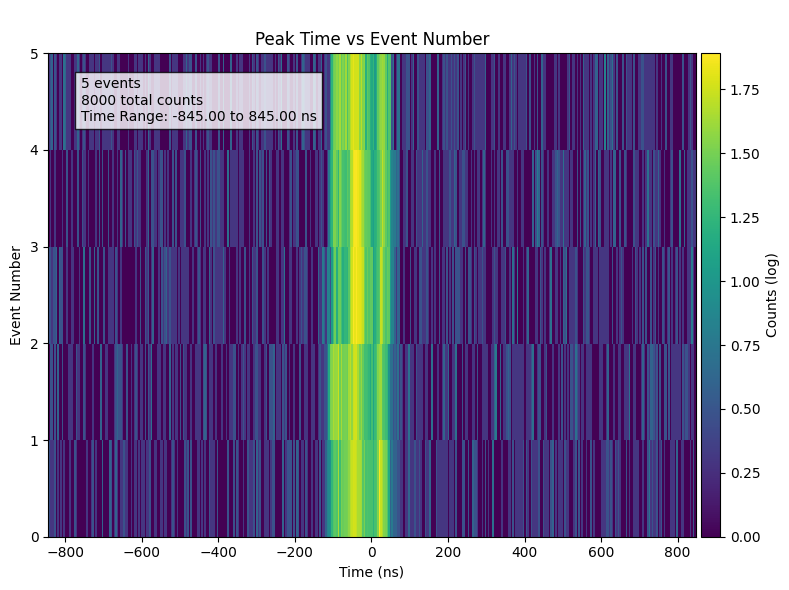

In [483]:
t_range_begin_ns = 0
# t_range = (t_range_begin_ns, t_range_begin_ns + 1695*50)
t_range = (0, 100.e6)
delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=1,
                                                                        fft_time_range_ns=t_range)

means = []
normalized_delta_trains_per_event = []

for delta_train in delta_trains_per_event:
    d: np.ndarray = symmetric_mod(delta_train, new_period).astype(float)
    means.append(np.mean(d))

total_mean = np.mean(means)
normalized_delta_trains_per_event = [symmetric_mod(d - total_mean, new_period) for d in delta_trains_per_event]
print(f"Adjusted delta train mean by {total_mean:.3f} ns")

plot_2d_histogram_time_vs_event_number(
    normalized_delta_trains_per_event,
    bin_width = 4,
    units='ns',
    t_range = (-900, 900),
    # t_range=t_range
)

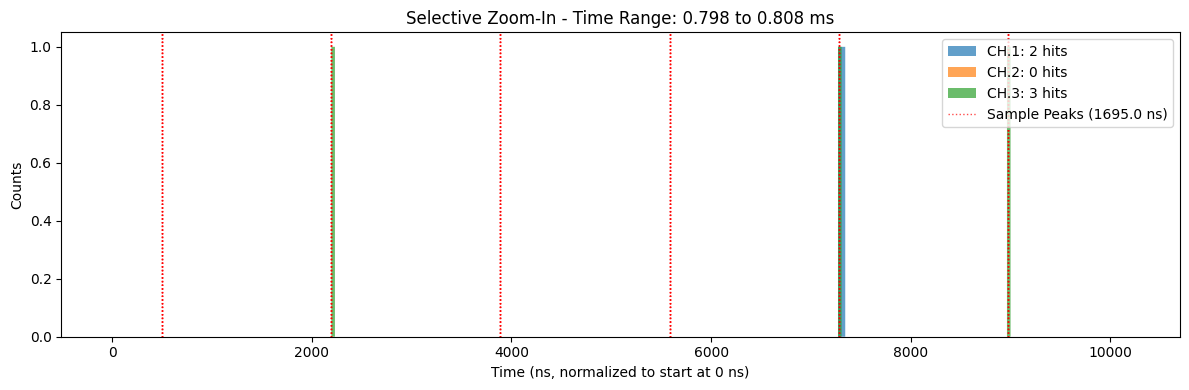

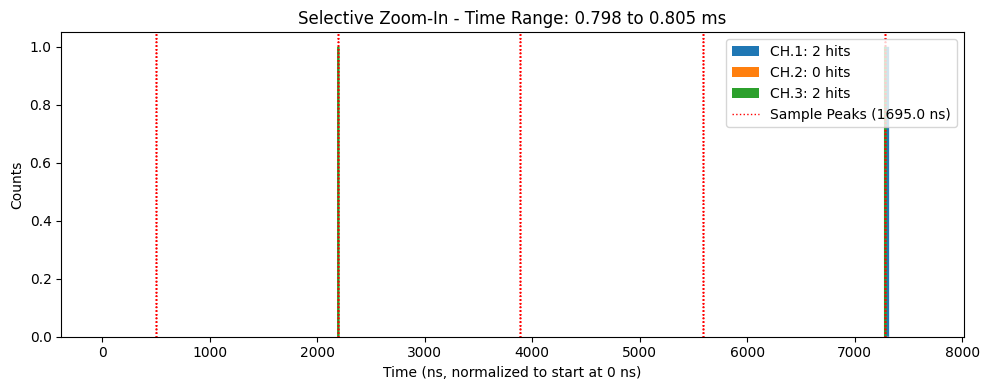

In [400]:
# Check this plot again after period and mean corrections
start = 0.8e6
start = start - start % new_period - 500
end = start + new_period * 6
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=0.7, bin_size_ns=36,
                  fig_size = (12, 4), sample_offset = 500, legend=True,
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms",
                  file_name=f"img/{hc.folder_name}/{hc.file_name}_zoomed_corrected_1d_histogram.svg",
                  units="ns")

end = start + new_period * 4.5
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True, sample_offset=500,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=1, bin_size_ns=24,
                  fig_size=(10, 4), legend=True,
                  # file_name=f"img/{hex_check.folder_name}/zoomed_histogram.png",
                  file_name=f"img/{hc.folder_name}/MOP037_f4.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms")

In [468]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#
# plot_2d_histogram_delta_train(delta_trains[2], period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 1,
#                               colors=['Reds'], bin_width_ns = 4,
#                               n_slices=125, alpha=1,
#                               title = f"2D Histogram, before/after corrections",
#                               )
#
# plot_2d_histogram_delta_train(new_delta_trains[2], new_period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 2,
#                               colors=['Greens'], bin_width_ns = 4,
#                               n_slices=125, alpha=0.5,
#                               )
#
# plt.tight_layout()
# plt.savefig(f"img/{hc.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.savefig(f"img/{hc.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.show()

for channel, new_delta_train in enumerate(new_delta_trains):
    plot_2d_histogram_delta_train(new_delta_train, new_period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hc.folder_name}/2d_histogram_corrected.png",
                                  colors=['inferno'],
                                  n_slices=40,
                                  figsize=(10, 8),
                                  title=f"2D Histogram (Channel {channel + 1})",
                                  )

all_trains = []
all_trains = np.concatenate(new_delta_trains)  # combine all delta trains into one
plot_2d_histogram_delta_train(all_trains, new_period, common_title_text=common_title_text,
                              channel = 1,
                              # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                              file_name=f"img/{hc.folder_name}/2d_histogram_corrected.png",
                              colors=['Blues'],
                              n_slices=125, bin_width_ns=4,
                              figsize=(8, 4),
                              title="2D Histogram (All Channels Combined)",
                              )


In [484]:
from socketudp.extinction_plots import plot_2d_histogram_delta_train_compare
#
# fig, ax = plt.subplots(1, 1, figsize=(9.5, 4))
# plot_2d_histogram_delta_train_compare(
#     before_delta=delta_trains[2],
#     after_delta=new_delta_trains[2],
#     before_period_ns=period,
#     after_period_ns=new_period,      # or period; both are fine as long as one is used for binning
#     common_title_text=common_title_text,
#     fig_ax=(fig, ax),
#     bin_width_ns=4,
#     n_slices=125,
#     mode="ratio",                         # "diff" or "ratio"
#     title="2D Histogram: after – before (Δcounts)",
# )
# plt.tight_layout()
# plt.savefig(f"img/{hc.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig(f"img/{hc.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()




In [403]:
# #######################################################
# EXTINCTION MEASUREMENT
# #######################################################

for i, normalized_delta_train in enumerate(normalized_delta_trains):
    # define +/- 125 ns window as "in-time", and everything else as "out-of-time"
    in_time_counts = np.sum(np.abs(normalized_delta_train) <= 125)
    out_of_time_counts = len(normalized_delta_train) - in_time_counts
    print(f"[CH{i+1}] In-time counts: {in_time_counts}, Out-of-time counts: {out_of_time_counts}")
    extinction_ratio = out_of_time_counts / (in_time_counts + out_of_time_counts)
    print(f"[CH{i+1}] Extinction ratio: {extinction_ratio:.3e} (out-of-time / total counts)")


[CH1] In-time counts: 1462, Out-of-time counts: 7888
[CH1] Extinction ratio: 8.436e-01 (out-of-time / total counts)
[CH2] In-time counts: 730, Out-of-time counts: 8620
[CH2] Extinction ratio: 9.219e-01 (out-of-time / total counts)
[CH3] In-time counts: 797, Out-of-time counts: 8553
[CH3] Extinction ratio: 9.148e-01 (out-of-time / total counts)


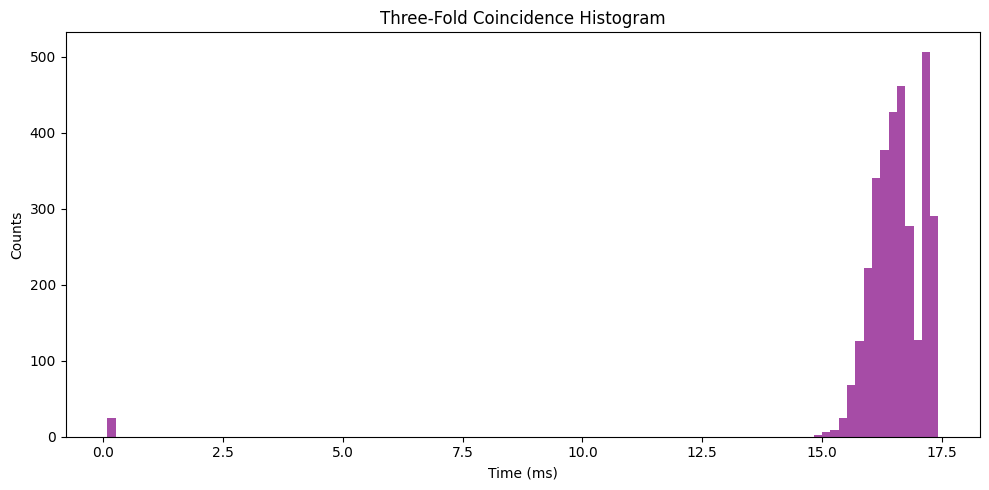

25 points
Detected Period: 1694.924 ns
In/Out Particles: 25/0
Extinction Ratio: 4.00e-02
(Add 1 OOT particle for calc.)
3268 points
Detected Period: 1694.924 ns
In/Out Particles: 2998/270
Extinction Ratio: 8.26e-02


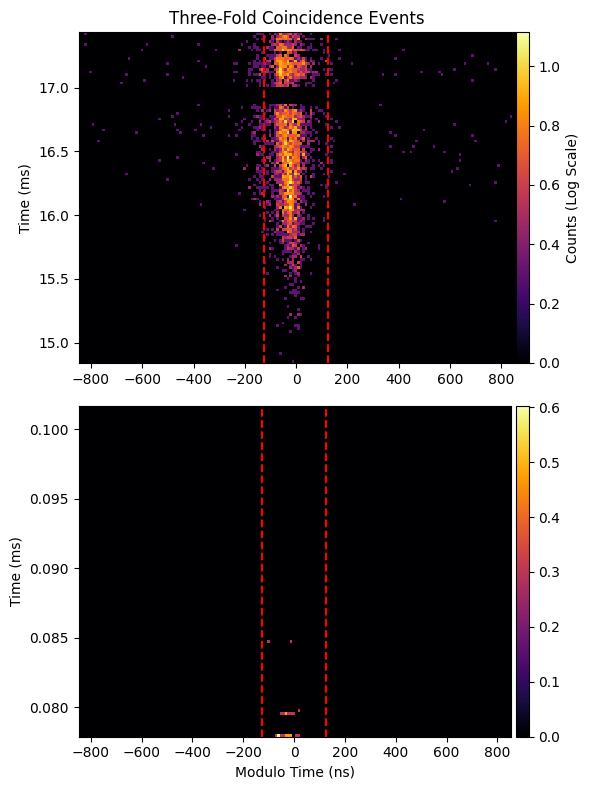

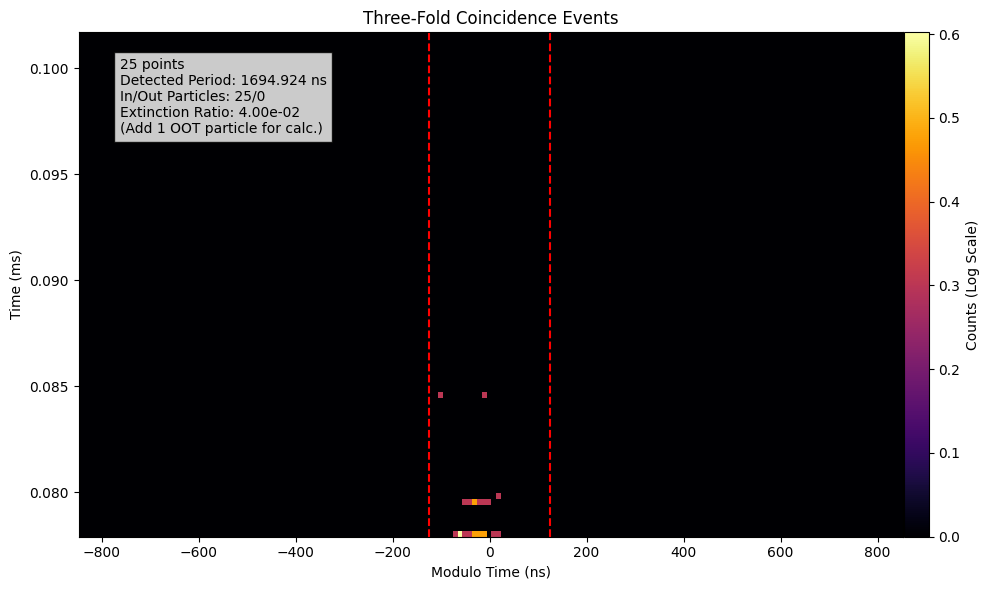

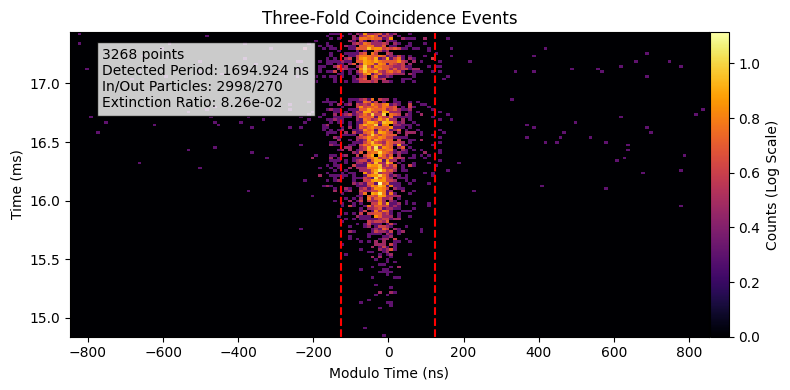

In [485]:
# ############################
# THREE FOLD COINCIDENCE
# ############################

average_points = get_three_fold_coincidence_points(new_delta_trains,
                                                   coincidence_window_ns=300)

# average points is now a simple list of timestamps, plot on a histogram
if average_points.size > 0:
    three_fold_title = re.sub(r"\nTime Range: .*? ms", "", common_title_text)
    plt.figure(figsize=(10, 5))
    plt.hist(average_points / 1e6, bins=100, color='purple', alpha=0.7)
    plt.xlabel("Time (ms)")
    plt.ylabel("Counts")
    plt.title("Three-Fold Coincidence Histogram")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------

    fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    # Plot two-part combined 2D histogram with disjointed time-axis in same figure
    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[1]), subplot_no = 2,
                                  common_title_text="Three-Fold Coincidence Events)",
                                  colors=['inferno'],
                                  file_name=f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=False, t_range=(0, 2e6))

    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[0]), subplot_no = 1,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'], file_name=f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=False, t_range=(13.5e6, np.inf))

    file_name = f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram_combined.svg"
    if file_name:
        plt.savefig(file_name, dpi=300)
    plt.show()

    # ------------------------------------------------------------------
    # plot individual histograms of chosen times
    plot_2d_histogram_delta_train(average_points, new_period,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'],
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram.svg",
                                  n_slices=80,
                                  figsize=(10, 6), textbox=True, t_range=(0, 2e6))
    plot_2d_histogram_delta_train(average_points, new_period,
                              common_title_text="Three-Fold Coincidence Events",
                              colors=['inferno'], n_slices=120,
                              figsize=(8, 4), textbox=True, t_range=(13.5e6, np.inf))

[CH1] Event 20: 1600 peaks heights(62 from t = 0.0 to 990000.0 ns).
[CH1] Event 21: 1550 peaks heights(96 from t = 0.0 to 990000.0 ns).
[CH1] Event 22: 1550 peaks heights(56 from t = 0.0 to 990000.0 ns).
[CH1] Event 23: 1550 peaks heights(61 from t = 0.0 to 990000.0 ns).
[CH1] Event 24: 1550 peaks heights(46 from t = 0.0 to 990000.0 ns).
[CH1] Event 25: 1550 peaks heights(76 from t = 0.0 to 990000.0 ns).
[CH1] Received 6 delta trains


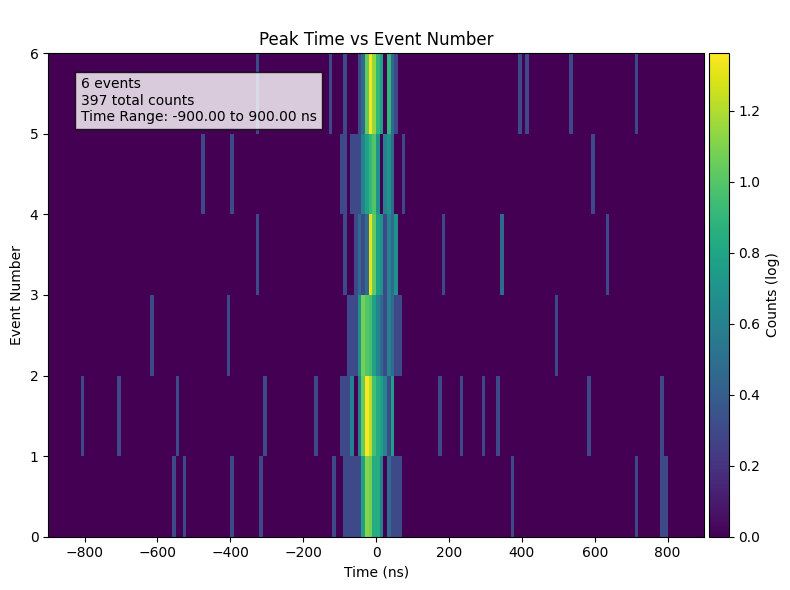

[CH2] Event 20: 1600 peaks heights(26 from t = 0.0 to 990000.0 ns).
[CH2] Event 21: 1550 peaks heights(39 from t = 0.0 to 990000.0 ns).
[CH2] Event 22: 1550 peaks heights(26 from t = 0.0 to 990000.0 ns).
[CH2] Event 23: 1550 peaks heights(30 from t = 0.0 to 990000.0 ns).
[CH2] Event 24: 1550 peaks heights(23 from t = 0.0 to 990000.0 ns).
[CH2] Event 25: 1550 peaks heights(25 from t = 0.0 to 990000.0 ns).
[CH2] Received 6 delta trains


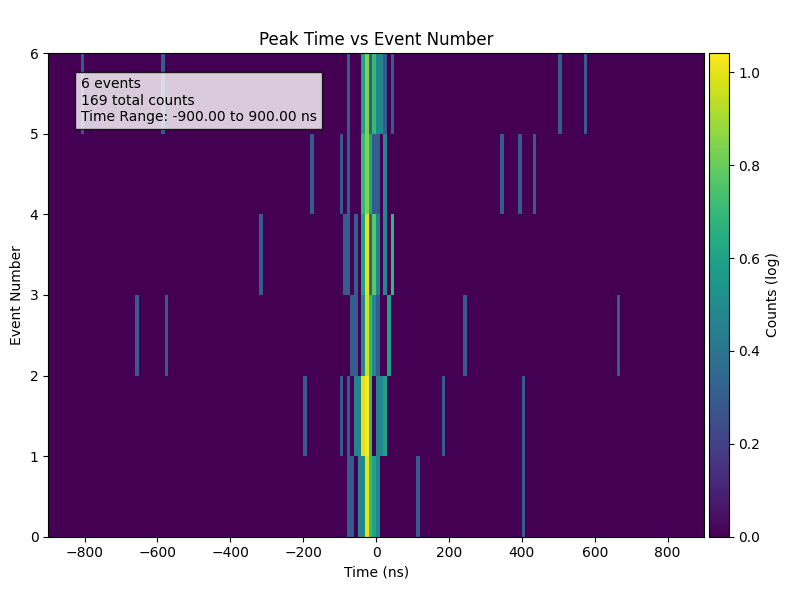

[CH3] Event 20: 1600 peaks heights(25 from t = 0.0 to 990000.0 ns).
[CH3] Event 21: 1550 peaks heights(56 from t = 0.0 to 990000.0 ns).
[CH3] Event 22: 1550 peaks heights(23 from t = 0.0 to 990000.0 ns).
[CH3] Event 23: 1550 peaks heights(31 from t = 0.0 to 990000.0 ns).
[CH3] Event 24: 1550 peaks heights(27 from t = 0.0 to 990000.0 ns).
[CH3] Event 25: 1550 peaks heights(31 from t = 0.0 to 990000.0 ns).
[CH3] Received 6 delta trains


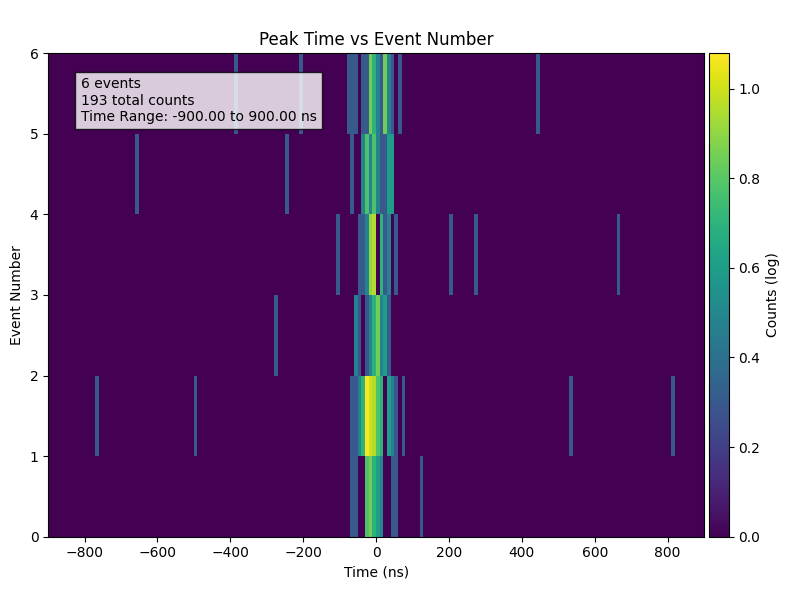

[CH4] Received 0 delta trains


In [405]:
# modulated version of three-fold coincidence plot

for i in range(4):
    delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=i+1,
                                                                            fft_time_range_ns=(0e6, 0.99e6),
                                                                            period=period)
    print(f"[CH{i+1}] Received {len(delta_trains_per_event)} delta trains")

    # skip if no data
    if len(delta_trains_per_event) == 0:
        continue

    # subtract mean out
    means = []
    for i in delta_trains_per_event:
        if len(i) == 0:
            continue
        means.append(np.mean(i))

    total_mean = np.mean(means)
    new_delta_trains_per_event = []
    for i in delta_trains_per_event:
        new_delta_trains_per_event.append(symmetric_mod(np.array(i) - total_mean, period))


    plot_2d_histogram_time_vs_event_number(
        new_delta_trains_per_event,
        bin_width = 10,
        units='ns',
        t_range=(-900, 900),
        binrange=(-900, 900)
    )